In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import re

In [110]:
train = pd.read_csv("./train.csv") #Datensatz angeben


In [111]:
# dropping irrelevant columns
train.drop('Cabin', axis=1, inplace=True)
train.drop('PassengerId', axis=1, inplace=True)
train.drop('Ticket', axis=1, inplace=True)
#train = train.dropna(subset=['Embarked'])
train.fillna(train['Embarked'].mode()[0])

# Replace Sex Values male=1, female=2
train['Sex'] = train['Sex'].str.lower().map({'male': 1, 'female': 2}).fillna(train['Sex'])# Count rows with NaN values in any column
train['Embarked'] = train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

train['Age'] = train['Age'].fillna(train['Age'].median())
#train = train.dropna(subset=['Age']) # Had no effect on the result 0,07 -> 0,08
train


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,2.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,71.2833,0.0
2,1,3,"Heikkinen, Miss. Laina",2,26.0,0,0,7.9250,2.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,53.1000,2.0
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,2.0
...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,13.0000,2.0
887,1,1,"Graham, Miss. Margaret Edith",2,19.0,0,0,30.0000,2.0
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",2,28.0,1,2,23.4500,2.0
889,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,30.0000,0.0


In [112]:
# Modify Dataset and Exploration

nan_count = train.isna().any(axis=1).sum()
# To identify which columns have NaN values and count them
nan_columns = train.isna().sum()
print(nan_columns)

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64


In [113]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
train['IsAlone'] = np.where(train['FamilySize'] == 1, 1, 0)

# Extract Title from Name
def get_title(name):
    title_search = re.search(r' ([A-Za-z]+)\.', name)  # Verwenden eines rohen String-Literals
    if title_search:
        return title_search.group(1)
    return ""

train['Title'] = train['Name'].apply(get_title)
train['Title'] = train['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')
train['Title'] = train['Title'].map({"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Rare": 4})
train['Title'] = train['Title'].fillna(0)
train.drop('Name', axis=1, inplace=True)
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title
0,0,3,1,22.0,1,0,7.2500,2.0,2,0,0
1,1,1,2,38.0,1,0,71.2833,0.0,2,0,2
2,1,3,2,26.0,0,0,7.9250,2.0,1,1,1
3,1,1,2,35.0,1,0,53.1000,2.0,2,0,2
4,0,3,1,35.0,0,0,8.0500,2.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,2.0,1,1,4
887,1,1,2,19.0,0,0,30.0000,2.0,1,1,1
888,0,3,2,28.0,1,2,23.4500,2.0,4,0,1
889,1,1,1,26.0,0,0,30.0000,0.0,1,1,0


In [114]:
features = ["Sex", "Pclass", "Fare", "Age", "FamilySize", "Title"]
x = train[features]
y = train["Survived"]
# Splitting the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# Checking the sizes of the datasets
print("x_train size:", x_train.shape)
print("x_test size:", x_test.shape)
print("y_train size:", y_train.shape)
print("y_test size:", y_test.shape)





x_train size: (712, 6)
x_test size: (179, 6)
y_train size: (712,)
y_test size: (179,)


In [115]:
def evaluate_model(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

In [116]:
# Applying Logistic Regression
model = LogisticRegression(max_iter=2000, solver='liblinear', random_state=42)
model.fit(x_train, y_train)

LogisticRegression(max_iter=2000, random_state=42, solver='liblinear')

In [120]:
'''
best = 1
best_acc = 0
for i in range(1, 800):
    rf_model = RandomForestClassifier(n_estimators=i, random_state=42)
    rf_model.fit(x_train, y_train)
    rf_y_pred = rf_model.predict(x_test)
    if accuracy_score(y_test, rf_y_pred) > best_acc:
        best = i
        best_acc = accuracy_score(y_test, rf_y_pred)
        
rf_model = RandomForestClassifier(n_estimators=best, random_state=42)
rf_model.fit(x_train, y_train)
rf_y_pred = rf_model.predict(x_test)
print(best)
print("Random Forest Evaluation:")
evaluate_model(y_test, rf_y_pred)
'''
# Hyperparameter-Tuning für Logistic Regression
lr_params = [
    {'penalty': ['l1'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga'], 'max_iter': [10000]},
    {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear', 'saga'], 'max_iter': [10000]}
]
lr_grid = GridSearchCV(LogisticRegression(random_state=42), lr_params, cv=5)
lr_grid.fit(x_train, y_train)
lr_best = lr_grid.best_estimator_

# Hyperparameter-Tuning für Random Forest
rf_params = {
    'n_estimators': [100, 120, 150, 200, 300],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [4, 6, 8],
    'criterion': ['gini', 'entropy']
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5)
rf_grid.fit(x_train, y_train)
rf_best = rf_grid.best_estimator_

# %%
# Applying best Logistic Regression model
lr_best.fit(x_train, y_train)
lr_y_pred = lr_best.predict(x_test)

# Applying best Random Forest model
rf_best.fit(x_train, y_train)
rf_y_pred = rf_best.predict(x_test)


In [122]:
print("Best parameters for Logistic Regression:", lr_grid.best_params_)
print("Best parameters for Random Forest:", rf_grid.best_params_)

# Evaluation of Logistic Regression
print("Best Logistic Regression Evaluation:")
evaluate_model(y_test, lr_y_pred)

# Evaluation of Random Forest
print("Best Random Forest Evaluation:")
evaluate_model(y_test, rf_y_pred)

# Cross-validation Logistic Regression
cv_scores = cross_val_score(lr_best, x, y, cv=10)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# Interpretation der Cross-Validation-Ergebnisse
'''
Die Cross-Validation hilft, die Generalisierbarkeit des Modells zu bewerten. 
Ein Mean Cross-Validation Score von ca. 0.8 zeigt, dass das Modell in verschiedenen Datenaufteilungen eine konstante Leistung erbringt. 
Die Streuung der Scores gibt auch Aufschluss über die Stabilität des Modells.
'''


Best parameters for Logistic Regression: {'C': 1, 'max_iter': 10000, 'penalty': 'l1', 'solver': 'saga'}
Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 150}
Best Logistic Regression Evaluation:
Accuracy: 0.7821229050279329
Confusion Matrix:
 [[87 18]
 [21 53]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82       105
           1       0.75      0.72      0.73        74

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179

Best Random Forest Evaluation:
Accuracy: 0.8100558659217877
Confusion Matrix:
 [[92 13]
 [21 53]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.72      0.76        74

    accuracy                         

'\nDie Cross-Validation hilft, die Generalisierbarkeit des Modells zu bewerten. \nEin Mean Cross-Validation Score von ca. 0.8 zeigt, dass das Modell in verschiedenen Datenaufteilungen eine konstante Leistung erbringt. \nDie Streuung der Scores gibt auch Aufschluss über die Stabilität des Modells.\n'

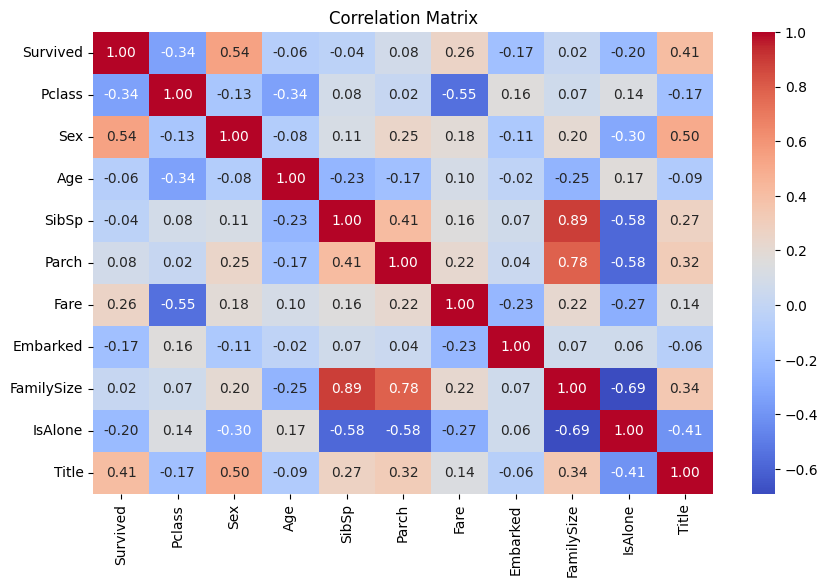

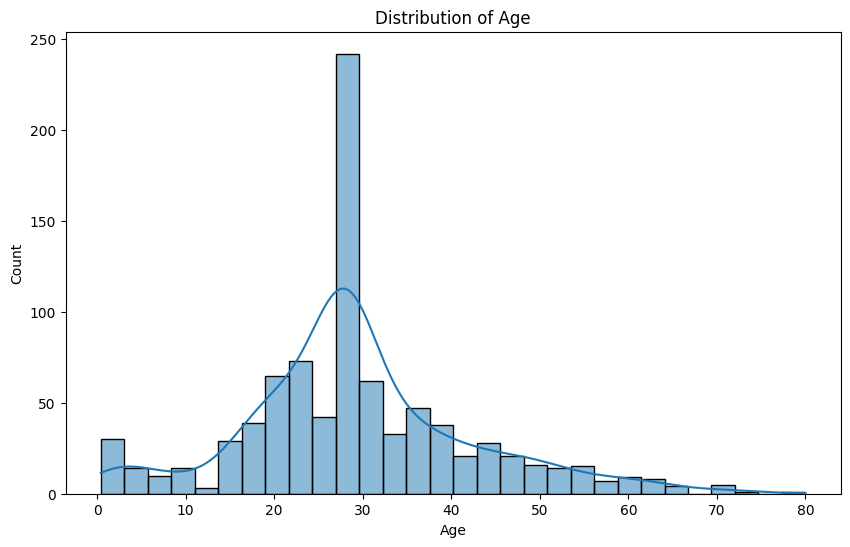

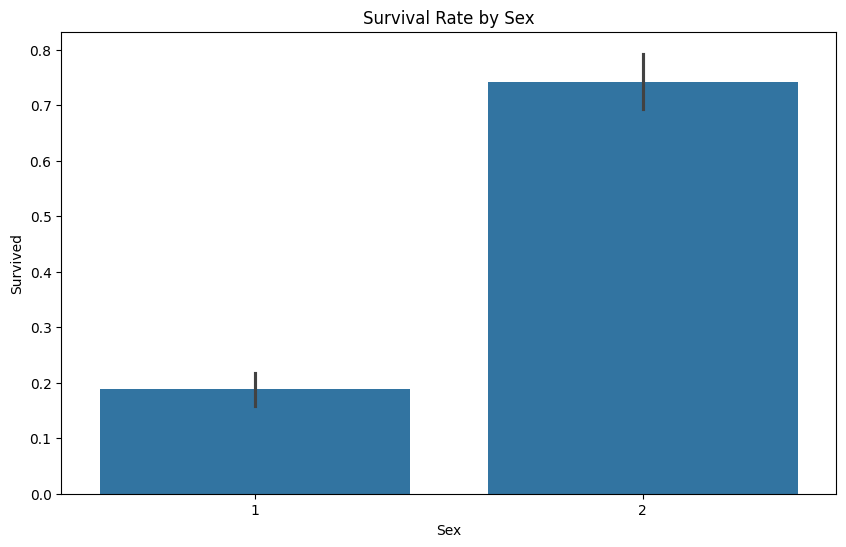

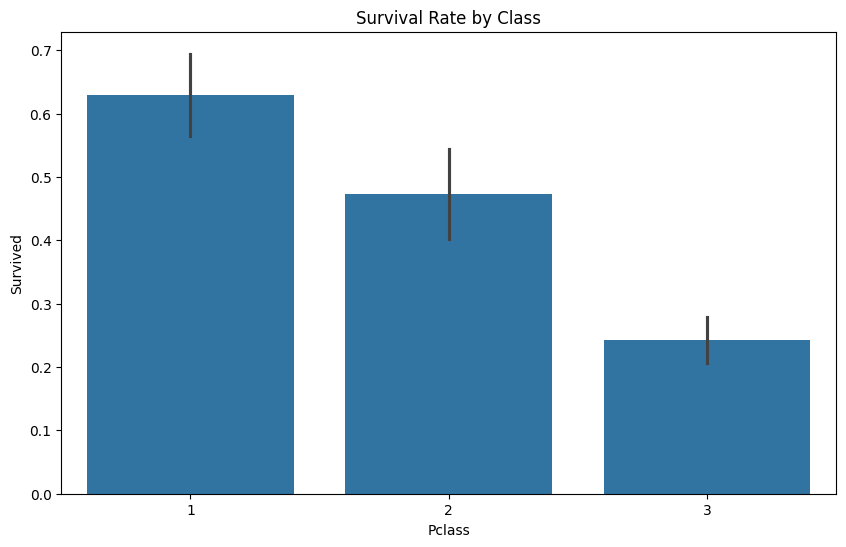

'\nKorrelation Matrix zeigt, dass die Überlebensrate am stärksten mit dem Geschlecht korreliert ist. außerderm ist die Klasse und der Titel stark korreliert.\n\nDie weiteren Plots zeigen die Verteilung des Alters, die Überlebensrate nach Geschlecht und Klasse. Was die korrelationen bestätigt.\n'

In [119]:
# Visual Explorative Data Analysis (EDA)
plt.figure(figsize=(10, 6))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Plotting the distribution of 'Age'
plt.figure(figsize=(10, 6))
sns.histplot(train['Age'], kde=True)
plt.title('Distribution of Age')
plt.show()

# Visualizing the survival rate by sex
plt.figure(figsize=(10, 6))
sns.barplot(x='Sex', y='Survived', data=train)
plt.title('Survival Rate by Sex')
plt.show()

# Visualizing the survival rate by class
plt.figure(figsize=(10, 6))
sns.barplot(x='Pclass', y='Survived', data=train)
plt.title('Survival Rate by Class')
plt.show()
train.corr()

'''
Korrelation Matrix zeigt, dass die Überlebensrate am stärksten mit dem Geschlecht korreliert ist. außerderm ist die Klasse und der Titel stark korreliert.

Die weiteren Plots zeigen die Verteilung des Alters, die Überlebensrate nach Geschlecht und Klasse. Was die korrelationen bestätigt.
'''